In [1]:
import sys
sys.path.append('../../')
from SynRBL.rsmi_utils import save_database, load_database, filter_data, extract_results_by_key

In [2]:
graph = load_database('../../Data/Validation_set/Jaworski/MCS/Final_Graph.json.gz')

In [3]:
graph

[{'smiles': ['N=C(O)C(Cl)(Cl)Cl'],
  'boundary_atoms_products': [[{'O': 2}]],
  'nearest_neighbor_products': [[{'C': 9}]],
  'issue': '',
  'Certainty': True,
  'R-id': 'USPTO_50K_24',
  'old_reaction': 'CC(C)=CCC\\C(C)=C\\COC(=N)C(Cl)(Cl)Cl>>CC(C)=CCCC(C)(NC(=O)C(Cl)(Cl)Cl)C=C',
  'sorted_reactants': ['CC(C)=CCC/C(C)=C/COC(=N)C(Cl)(Cl)Cl'],
  'carbon_balance_check': 'balanced',
  'mcs_results': ['[#6]-&!@[#6](-&!@[#6])=&!@[#6]-&!@[#6]-&!@[#6]-&!@[#6](-&!@[#6])=,-;!@[#6]-,=;!@[#6]']},
 {'smiles': [None, None, 'O'],
  'boundary_atoms_products': [None, None, [{'O': 0}]],
  'nearest_neighbor_products': [None, None, [{'C': 0}]],
  'issue': '',
  'Certainty': True,
  'R-id': 'USPTO_50K_95',
  'old_reaction': '[H]C([H])=O.CCNCC.CCCC(C)=O>>CCC(CN(CC)CC)C(C)=O',
  'sorted_reactants': ['CCCC(C)=O', 'CCNCC', 'C=O'],
  'carbon_balance_check': 'balanced',
  'mcs_results': ['[#6]-&!@[#6]-&!@[#6]-&!@[#6](-&!@[#6])=&!@[#8]',
   '[#6]-&!@[#6]-&!@[#7]-&!@[#6]-&!@[#6]',
   '[#6]']},
 {'smiles': ['N=N', 

In [11]:
from rdkit import Chem
rsmi = 'O=C(N)c1ccccc1>>c1ccc(cc1)N'
reactants = rsmi.split('>>')[0]
reactants_mol = Chem.MolFromSmiles(reactants)

products = rsmi.split('>>')[1]
products_mol = Chem.MolFromSmiles(products)

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdRascalMCES
from rdkit import rdBase
rdDepictor.SetPreferCoordGen(True)
print(rdBase.rdkitVersion)

2023.09.2


In [45]:
opts = rdRascalMCES.RascalOptions()
opts.allBestMCESs = True
opts.similarityThreshold = 0.5
results = rdRascalMCES.FindMCES(reactants_mol, products_mol, opts)

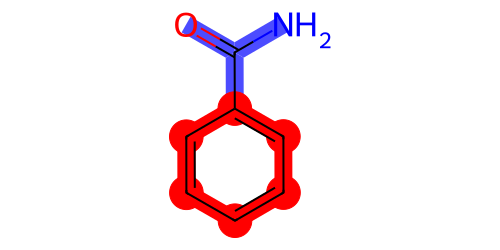

In [46]:
def extractHighlights(res):
    bondHighlights1 = {}
    bondHighlights2 = {}
    for bondPair in res.bondMatches():
        bondHighlights1[bondPair[0]] = (1.0, 0.0, 0.0)
        bondHighlights2[bondPair[1]] = (1.0, 0.0, 0.0)
    atomHighlights1 = {}
    atomHighlights2 = {}
    for atomPair in res.atomMatches():
        atomHighlights1[atomPair[0]] = (1.0, 0.0, 0.0)
        atomHighlights2[atomPair[1]] = (1.0, 0.0, 0.0)
    return bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2

def drawMCESMatch(mol1, bondHighlights, atomHighlights, highlightNonmatches=(0.3,0.3,1.0)):    
    d = rdMolDraw2D.MolDraw2DSVG(500, 250)
    if highlightNonmatches:
        for bnd in mol1.GetBonds():
            if bnd.GetIdx() not in bondHighlights:
                bondHighlights[bnd.GetIdx()] = highlightNonmatches
    d.DrawMolecule(mol1,highlightAtoms=atomHighlights.keys(),highlightBonds=bondHighlights.keys(),
                   highlightAtomColors=atomHighlights,highlightBondColors=bondHighlights)
    d.FinishDrawing()
    return d

res= results[0]
bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(res)
d = drawMCESMatch(reactants_mol, bondHighlights1, atomHighlights1)
SVG(d.GetDrawingText())

In [42]:
results[0]

In [44]:
print(f'{results[0].smartsString}')

c1:c:c:c:c:c:1


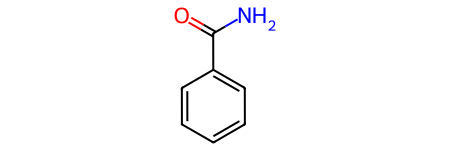

In [37]:
reactants_mol

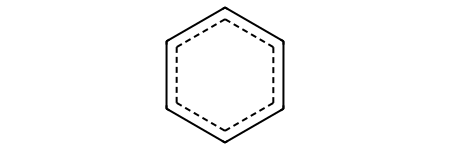

In [39]:
Chem.MolFromSmarts(results[0].smartsString)

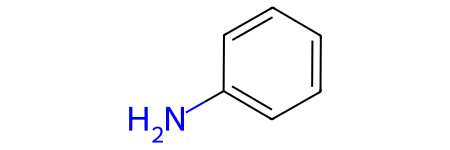

In [17]:
products_mol

In [15]:
results

[]

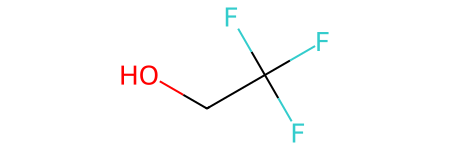

In [7]:
from rdkit import Chem
Chem.MolFromSmiles('OCC(F)(F)F')

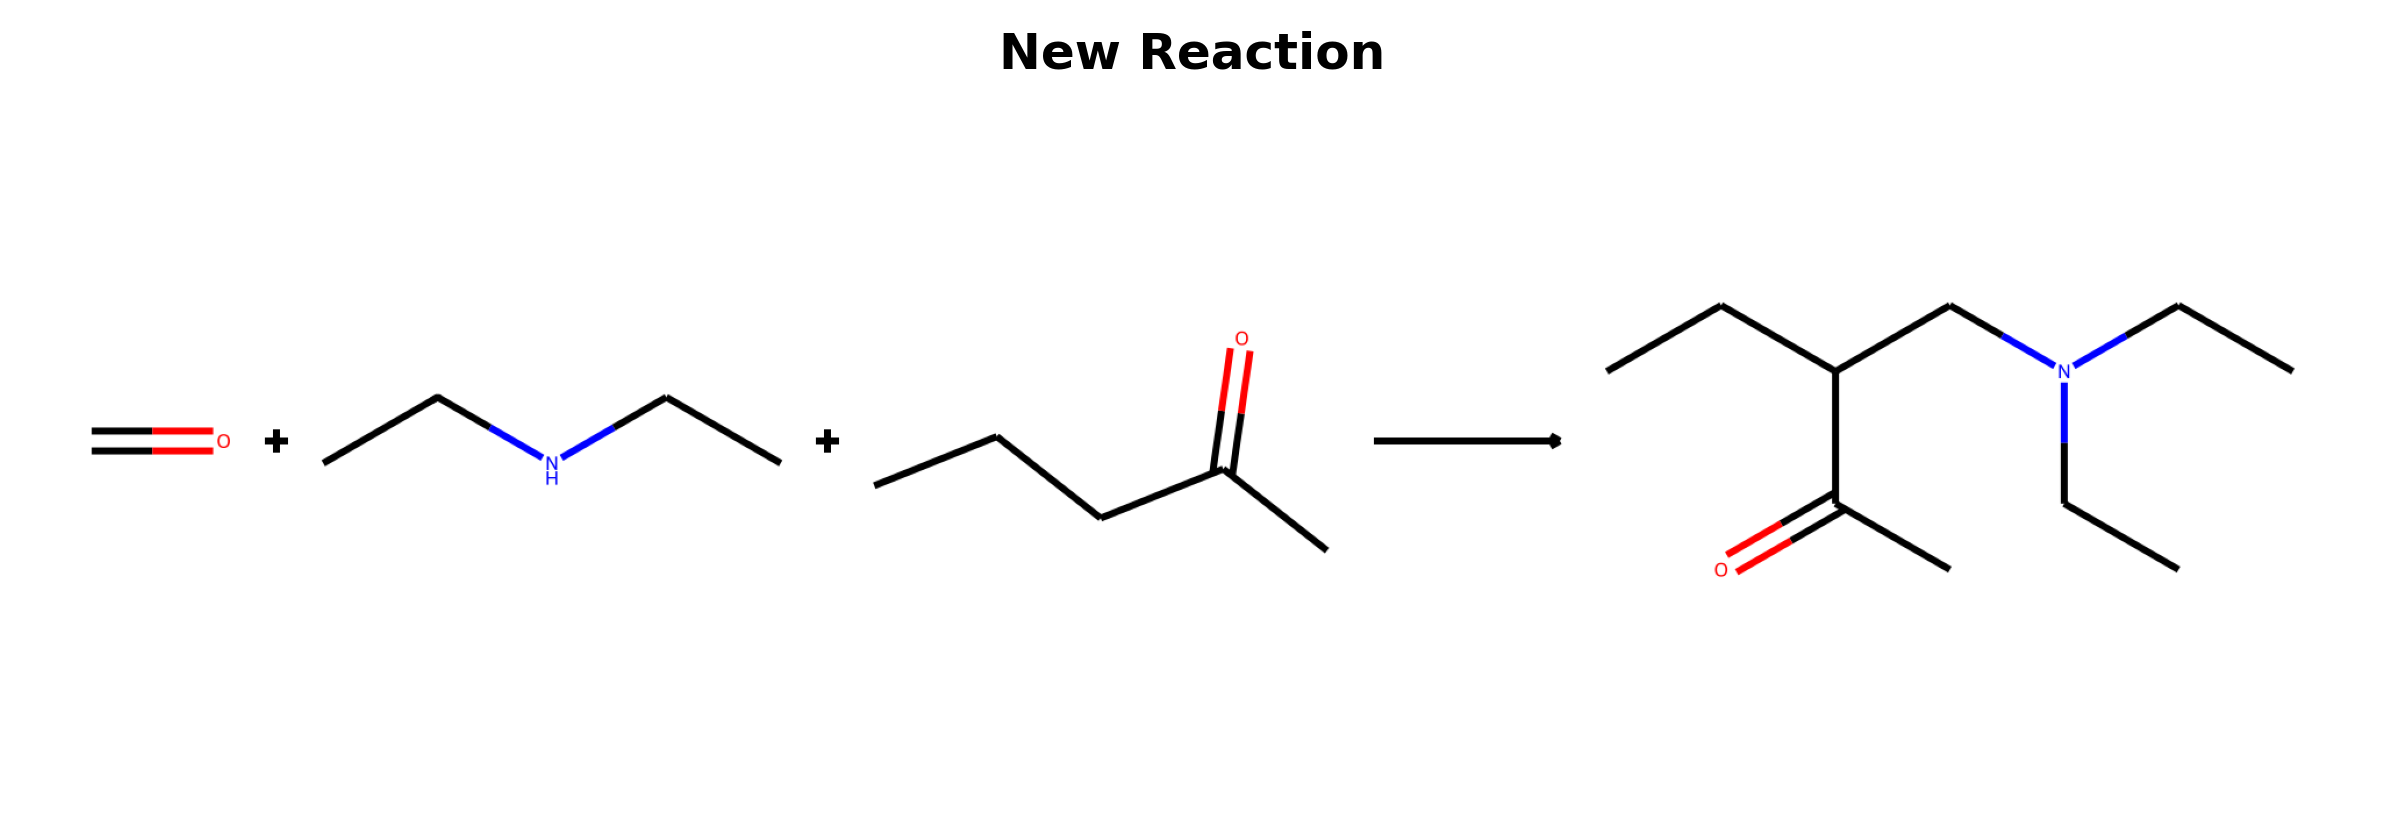

In [5]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(graph[1], 'old_reaction', 'old_reaction', compare=False, show_atom_numbers=False)

In [60]:
from rdkit import Chem

def count_rings(smiles):
    """
    Count the number of rings in a chemical compound given its SMILES representation.

    :param smiles: A string representing the chemical compound in SMILES format.
    :return: The number of rings in the compound.
    """
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    # Check if the molecule object is valid
    if not mol:
        raise ValueError("Invalid SMILES string")

    # Use RDKit's GetSSSR function to find the smallest set of smallest rings
    num_rings = len(Chem.GetSSSR(mol))

    return num_rings

def check_rings_reactions(reactants_smiles, products_smiles):
    """
    Count the number of rings in a chemical compound given its SMILES representation.

    :param smiles: A string representing the chemical compound in SMILES format.
    :return: The number of rings in the compound.
    """
    # Convert the SMILES string to an RDKit molecule object
    reactants_mol = Chem.MolFromSmiles(reactants_smiles)
    products_mol = Chem.MolFromSmiles(products_smiles)

    # Check if the molecule object is valid
    if not reactants_mol or not products_mol:
        raise ValueError("Invalid SMILES string")

    # Use RDKit's GetSSSR function to find the smallest set of smallest rings
    reactants_num_rings = len(Chem.GetSSSR(reactants_mol))
    products_num_rings = len(Chem.GetSSSR(products_mol))

    if reactants_num_rings >= products_num_rings:
        return False
    else:
        return True
    

reactants_smiles = 'C=C-C=C.C=C'
products_smiles = 'C1CCCC=C1'

check_rings_reactions(reactants_smiles, products_smiles)

True

True

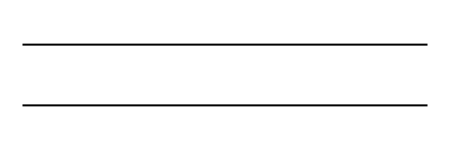

In [50]:


# Example usage
smiles_example = 'C1=CC=CC=C1'  # Benzene
print("Number of rings:", count_rings(smiles_example))

Number of rings: 1


In [52]:
count_rings('C1=CC=C(C=C1)N2C=CC=N2')

2